In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# DISC\\Python
cwd = "..\\..\\"
cwd_Images_Raw = cwd + "\\Sentinel-2 Images Raw"
cwd_Images_Processed = cwd + "\\Sentinel-2 Images Processed"
cwd_Images_Results = cwd + "\\Results"

In [4]:
df = pd.read_excel(cwd + "\\Results\\Variogram - Fitting Results.xlsx")
df.head()

,Number,Site,Latitude,Longitude,Main Ecosystem,FLOX Activity,Reference Network,Variogram Fitting,Strange,CV 30,...,CV 100,Sill 100,CV 300,Sill 300,CV 600,Sill 600,CV 900,Sill 900,Homo Test 600,Homo Test 900
0,96,US-LIN,41.179700,-96.440390,Crop,Yes,FLOX,Bad,NaN,0.008956,...,0.019019,3.883706,0.057523,31.142912,0.048321,21.122576,0.211051,347.913864,Yes,Yes
1,48,GHNA,-23.601530,15.125890,NaN,NaN,HYPERNET,Bad,NaN,0.056635,...,0.047539,0.083282,0.050606,0.090163,0.057228,0.114099,0.066343,0.150287,NaN,NaN
2,4,AT-Mmg,47.316700,10.970300,Evergreen Forest,Yes,FLOX,Good,NaN,0.033692,...,0.059300,3.316349,0.056158,3.442307,0.058228,3.904039,0.065007,5.146960,Yes,Yes
3,99,US-SERC New,38.891407,-76.561638,Deciduous Forest,Possible,FLOX,Bad,NaN,0.019452,...,0.032547,8.365751,0.061249,27.780593,0.077073,45.531968,0.147946,141.550071,Yes,Yes
4,98,US-SERC,38.890130,-76.560000,Deciduous Forest,Possible,FLOX,Bad,NaN,0.036599,...,0.052084,17.183318,0.045821,14.340473,0.094402,61.144228,0.151240,156.993384,Yes,Yes


In [37]:
df_600 = df[['Site','CV 600','Sill 600', 'Variogram Fitting']].reset_index(drop = True)
df_600['Homo Test'] = df_600.apply(lambda x: 'Yes' if x['Variogram Fitting'] == 'Good' and x['CV 600'] <= 0.25 and x['Sill 600'] <= 80 else 'Yes' if x['Variogram Fitting'] == 'Bad' and x['CV 600'] <= 0.25 else 'No', axis = 1)
df_600.head()

,Site,CV 600,Sill 600,Variogram Fitting,Homo Test
0,US-LIN,0.048321,21.122576,Bad,Yes
1,GHNA,0.057228,0.114099,Bad,Yes
2,AT-Mmg,0.058228,3.904039,Good,Yes
3,US-SERC New,0.077073,45.531968,Bad,Yes
4,US-SERC,0.094402,61.144228,Bad,Yes


In [43]:
# Remove rows with sill greater than 1000
df_600_SillFilter = df_600.copy()
df_600_SillFilter = df_600_SillFilter[~(df_600_SillFilter['Sill 600']>1000)].reset_index(drop = True)
df_600_SillFilter = df_600_SillFilter[~(df_600_SillFilter['CV 600']>1)].reset_index(drop = True)
df_600_SillFilter['Sill 600'] = df_600_SillFilter['Sill 600'] / 1000
df_600_SillFilter['HI 600'] = df_600_SillFilter['CV 600'] * df_600_SillFilter['Sill 600']
df_600_SillFilter['Homo Test HI 600'] = df_600_SillFilter.apply(lambda x: 'Yes' if x['HI 600'] <= (0.25*0.08) else 'No', axis = 1)
df_600_SillFilter.head()

,Site,CV 600,Sill 600,Variogram Fitting,Homo Test,HI 600,Homo Test HI 600
0,US-LIN,0.048321,0.021123,Bad,Yes,0.001021,Yes
1,GHNA,0.057228,0.000114,Bad,Yes,0.000007,Yes
2,AT-Mmg,0.058228,0.003904,Good,Yes,0.000227,Yes
3,US-SERC New,0.077073,0.045532,Bad,Yes,0.003509,Yes
4,US-SERC,0.094402,0.061144,Bad,Yes,0.005772,Yes


In [61]:
df_600_SillFilter['Both Test'] = df_600_SillFilter.apply(lambda x: 0 if x['Homo Test'] == 'Yes' and x['Homo Test HI 600'] == 'Yes'
                                                         else 1 if x['Homo Test'] == 'Yes' and x['Homo Test HI 600'] == 'No'
                                                         else 2 if x['Homo Test'] == 'No' and x['Homo Test HI 600'] == 'Yes'
                                                         else 3, 
                                                         axis = 1)
df_600_SillFilter.head()

,Site,CV 600,Sill 600,Variogram Fitting,Homo Test,HI 600,Homo Test HI 600,Both Test
0,US-LIN,0.048321,0.021123,Bad,Yes,0.001021,Yes,0
1,GHNA,0.057228,0.000114,Bad,Yes,0.000007,Yes,0
2,AT-Mmg,0.058228,0.003904,Good,Yes,0.000227,Yes,0
3,US-SERC New,0.077073,0.045532,Bad,Yes,0.003509,Yes,0
4,US-SERC,0.094402,0.061144,Bad,Yes,0.005772,Yes,0


In [62]:
df_600_SillFilter['Both Test'].unique()

array([0, 2, 1, 3], dtype=int64)

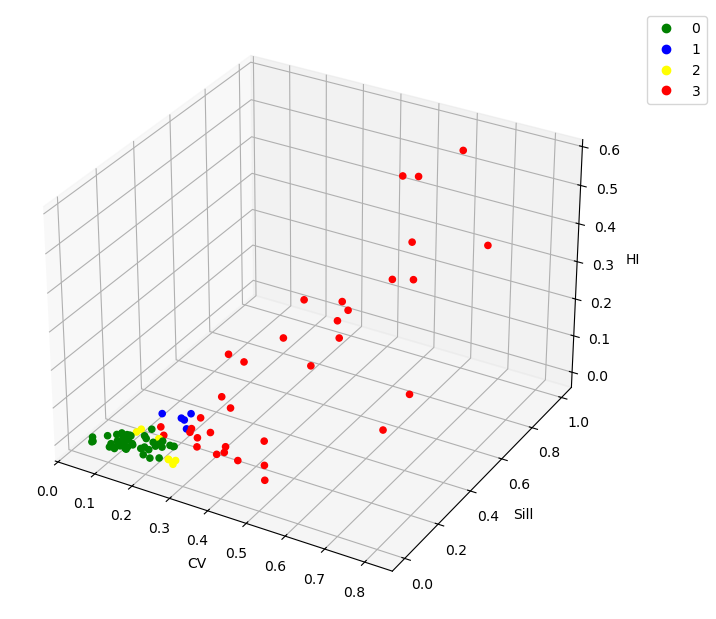

In [79]:
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

x = df_600_SillFilter['CV 600']
y = df_600_SillFilter['Sill 600']
z = df_600_SillFilter['HI 600']

customCMap = df_600_SillFilter['Both Test']

# get colormap from seaborn
cmap = ListedColormap(['green','blue','yellow','red'])

# plot
sc = ax.scatter3D(x, y, z, s=20, c=customCMap, marker='o', cmap = cmap, alpha=1)
ax.set_xlabel('CV')
ax.set_ylabel('Sill')
ax.set_zlabel('HI')

# legend
ax.legend(*sc.legend_elements(),bbox_to_anchor=(1.05, 1), loc=2)

# 0: both test passed; 
# 1: CV Sill test passed but HI test failed; 
# 2: CV Sill test failed but HI test passed;
# 3: both test failed

In [67]:
sc.legend_elements()

([<matplotlib.lines.Line2D at 0x26db1ba89e0>,
 ['$\\mathdefault{0}$',
  '$\\mathdefault{1}$',
  '$\\mathdefault{2}$',
  '$\\mathdefault{3}$'])